In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import yaml
import glob
import json
from tqdm import tqdm

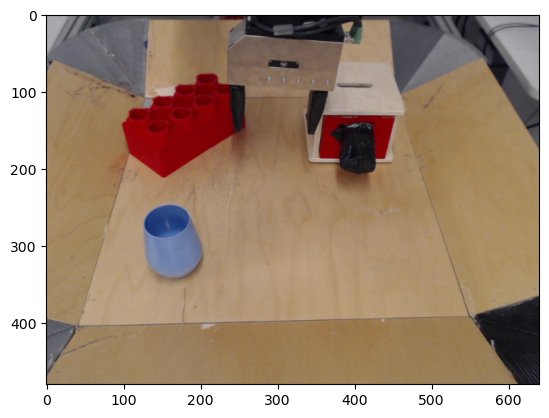

In [5]:
data = np.load('../data/onpolicy_eval/baselines-new-drawer-0.npy', allow_pickle=True)
image = cv2.cvtColor(data[0]["observations"][0]["hires_image_observation"], cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [6]:
def visualize_structure(data, get_length=False, name="root"):
    if isinstance(data, dict):
        node = {f"{name} (dict)": {}}
        for key, value in data.items():
            node[f"{name} (dict)"][key] = visualize_structure(data=value, name=key, get_length=get_length)
        return node
    elif isinstance(data, list):
        elements = [visualize_structure(data=data[0], name=f"{name}_0", get_length=get_length)] if data else []
        if len(data) > 1:
            elements.append("...")
        node = {f"{name} (list, length={len(data) if get_length else "0"})": elements}
        return node
    elif isinstance(data, np.ndarray):
        if data.dtype == object:
            elements = [visualize_structure(data=data[0], name=f"{name}_0", get_length=get_length)] if len(data) > 0 else []
            if len(data) > 1:
                elements.append("...")
            node = {f"{name} (np.array, dtype=object, length={len(data) if get_length else "0"})": elements}
        else:
            shape_str = tuple(data.shape) if data.ndim > 1 else data.shape[0]
            node = {f"{name} (np.array, shape={shape_str}, dtype={data.dtype})": None}
        return node
    else:
        return {f"{name} ({type(data).__name__})": None}

In [14]:
tree = visualize_structure(data=data, get_length=True)
yaml_str = yaml.dump(tree, default_flow_style=False)
print(yaml_str)

root (np.array, dtype=object, length=8):
- root_0 (dict):
    actions:
      actions (np.array, shape=(75, 4), dtype=float32): null
    agent_infos:
      agent_infos (list, length=75):
      - agent_infos_0 (dict): {}
      - '...'
    env_infos:
      env_infos (list, length=75):
      - env_infos_0 (dict):
          ContextualEnv/old_reward:
            ContextualEnv/old_reward (int): null
          hand_distance:
            hand_distance (float64): null
          hand_success:
            hand_success (float64): null
      - '...'
    next_observations:
      next_observations (np.array, dtype=object, length=75):
      - next_observations_0 (dict):
          achieved_goal:
            achieved_goal (np.array, shape=3, dtype=float64): null
          desired_goal:
            desired_goal (np.array, shape=3, dtype=float64): null
          hires_image_observation:
            hires_image_observation (np.array, shape=(480, 640, 3), dtype=uint8): null
          image_desired_goal:
    

In [17]:
def count_unique_structure_in_files(files, get_length=False):
    unique_structures = set()
    
    for file in tqdm(files):
        try:
            data = np.load(file, allow_pickle=True)
            for _, struct in enumerate(data): # trajectories
                struct_repr = visualize_structure(struct, get_length)
                struct_hash = json.dumps(struct_repr, sort_keys=True)
                unique_structures.add(struct_hash)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
        
    return len(unique_structures), unique_structures

In [13]:
files = glob.glob("../data/**/*.npy", recursive=True)
print("Number of files:", len(files))
print("Number of trajectories:", sum(len(np.load(file, allow_pickle=True)) for file in files))

Number of files: 299
Number of trajectories: 2492


In [ ]:
num_unique, unique_hashes = count_unique_structure_in_files(files, get_length=False)
print(f"Number of unique structures: {num_unique} \n(Without considering length of lists/arrays. Strictly topological.)")
if num_unique > 1:
    for hash in unique_hashes:
        print(hash)

Number of trajectories: 12501


  0%|          | 0/300 [00:00<?, ?it/s]

 92%|█████████▏| 276/300 [01:07<00:04,  5.95it/s]

Error processing file ../data/general/obj_open_pot4.npy: pickle data was truncated


100%|██████████| 300/300 [01:13<00:00,  4.10it/s]

Number of unique structures: 7 
(Without considering length of lists/arrays. Strictly topological.)
{"root (dict)": {"actions": {"actions (list, length=0)": [{"actions_0 (np.array, shape=4, dtype=float64)": null}, "..."]}, "agent_infos": {"agent_infos (list, length=0)": [{"agent_infos_0 (dict)": {"hand_distance": {"hand_distance (float64)": null}, "hand_success": {"hand_success (float64)": null}}}, "..."]}, "env_infos": {"env_infos (list, length=0)": [{"env_infos_0 (dict)": {"hand_distance": {"hand_distance (float64)": null}, "hand_success": {"hand_success (float64)": null}}}, "..."]}, "next_observations": {"next_observations (list, length=0)": [{"next_observations_0 (dict)": {"achieved_goal": {"achieved_goal (np.array, shape=3, dtype=float64)": null}, "desired_goal": {"desired_goal (np.array, shape=3, dtype=float64)": null}, "hires_image_observation": {"hires_image_observation (np.array, shape=(480, 640, 3), dtype=uint8)": null}, "image_observation": {"image_observation (np.array, sha

In [ ]:
unique_structures = [json.loads(hash) for hash in unique_hashes]
with open("unique_structures.yaml", "w") as f:
    yaml.dump(unique_structures, f, default_flow_style=False, allow_unicode=True)